In [2]:
%load_ext autoreload
%autoreload 2 

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import time
import torchvision
import numpy as np
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from aux_functions import angle_to_2d,is_accurate, plot_metrics, draw_gaze360_arrow
from datasets_utils import MPIIFaceGaze,Gaze360Dataset
from random import randint
from torch.nn import MSELoss

In [1]:
from transformers import TrainingArguments, Trainer
from typing import Optional, Union, Tuple
from dataclasses import dataclass
from transformers.modeling_outputs import ModelOutput
from transformers.models.mobilevit.modeling_mobilevit import (
    MobileViTPreTrainedModel,
    MobileViTModel,
    MobileViTConfig,
)

# Tarea

- Predecir el ángulo de la mirada a partir de fotografías de caras.
- Datasets: 
    - Gaze360
    - MPIIFaceGaze. [Link here](https://www.mpi-inf.mpg.de/de/departments/computer-vision-and-machine-learning/research/gaze-based-human-computer-interaction/its-written-all-over-your-face-full-face-appearance-based-gaze-estimation).
    

# 0. Configuración

CUDA

In [5]:
# CUDA configurations
os.environ["CUDA_LAUNCH_BLOCKING"]="1"

In [6]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:",device)

Device: cuda


# 1. Análisis de datos

> Nota: Los datasets deben ubicarse bajo la carpeta ./dataset

## 1.1. Estructura de los datos - cantidad de imágenes

In [154]:
import scipy.io
# Read dataset and get data
data = scipy.io.loadmat("./datasets/Gaze360/metadata.mat")
recording = data['recording'][0]
print(f"Hay {len(recording)} imagenes")

Hay 197588 imagenes


In [157]:
# Se crea una clase propia para facilitar la carga del dataset
ds = Gaze360Dataset("./datasets/Gaze360/",images_limit=4000,random=True,yaw_limits=[-1.1,1.1])

In [165]:
gaze_list = []
for data in ds:
    gaze = data["labels"]
    gaze_list.append(gaze)

## 1.2. Distribuciónde los datos


Los ángulos se representan mediante coordenadas polares, mediante los valores pitch y yaw. Para más inforación ver la siguiente imagen:

![head_ref.png](head_ref.png)

Vamos a analizar la distribución de datos de:

- Pitch: Movimiento vertical.
- Yaw: Movimiento horizontal.
- Angle_2d: Ángulo "plano", proyectado en 2 dimensiones

In [166]:
gaze_array = np.array(gaze_list)
pitch_array = gaze_array[:,1]
yaw_array = gaze_array[:,0]
projected_2d_angle_array = angle_to_2d(gaze_array)

### 1.2.1 Pitch

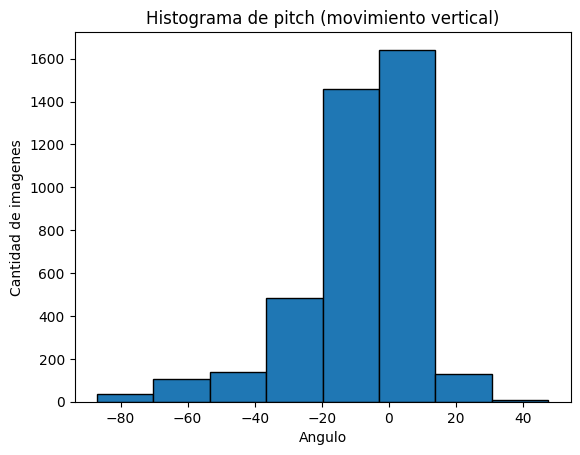

In [167]:
pitch_array_deg = np.rad2deg(pitch_array)
plt.hist(pitch_array_deg, bins=8, edgecolor='black')
plt.xlabel('Angulo')
plt.ylabel('Cantidad de imagenes')
plt.title('Histograma de pitch (movimiento vertical)')
plt.show()

### 1.2.2 Yaw

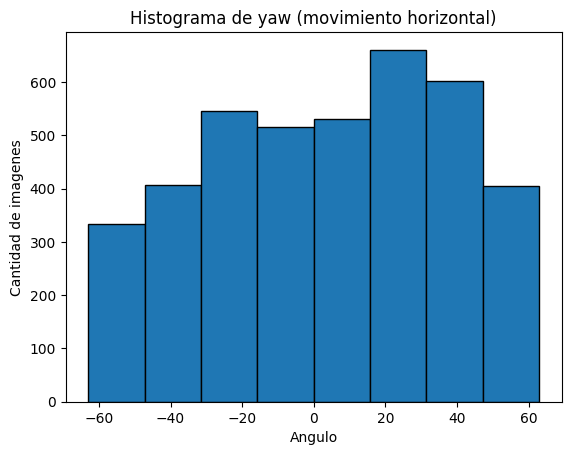

In [168]:
yaw_array_deg = np.rad2deg(yaw_array)
plt.hist(yaw_array_deg, bins=8, edgecolor='black')
plt.xlabel('Angulo')
plt.ylabel('Cantidad de imagenes')
plt.title('Histograma de yaw (movimiento horizontal)')
plt.show()

### 1.2.3 Proyección de ángulos 2D

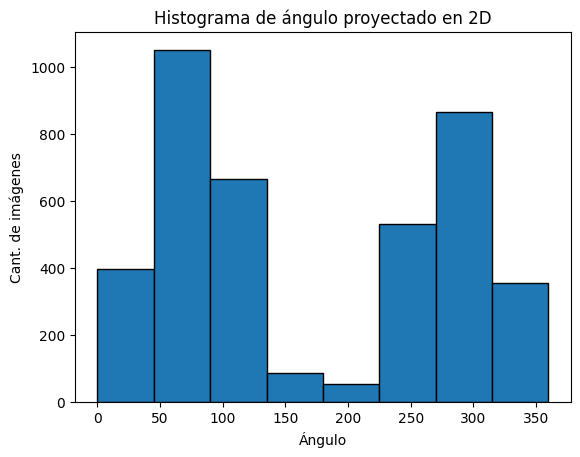

In [169]:
plt.hist(projected_2d_angle_array, bins=8, edgecolor='black')
plt.xlabel('Ángulo')
plt.ylabel('Cant. de imágenes')
plt.title('Histograma de ángulo proyectado en 2D')
plt.show()

### 1.2.4 Polar plot de pitch y yaw

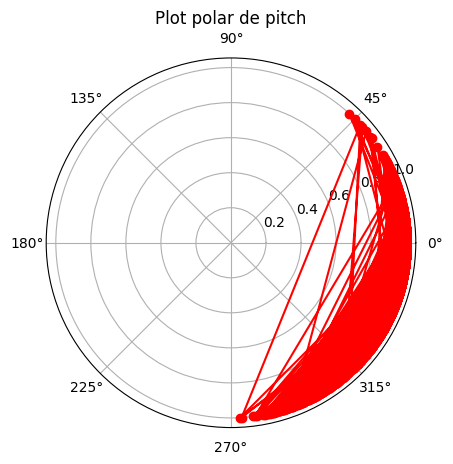

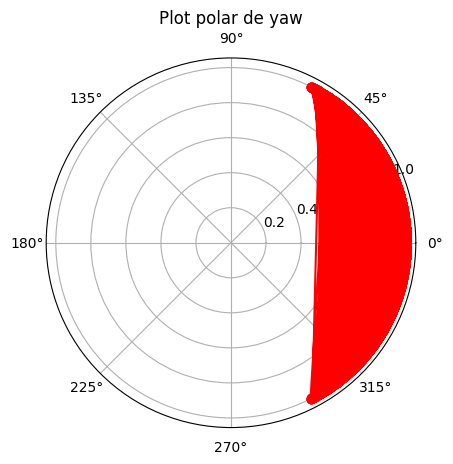

In [170]:
magnitude_array = np.ones_like(pitch_array)

# Pitch
plt.polar(pitch_array, magnitude_array, marker='o', linestyle='-', color='r')
plt.title('Plot polar de pitch')
# Show the plot
plt.show()

# Yaw
plt.polar(yaw_array, magnitude_array, marker='o', linestyle='-', color='r')
plt.title('Plot polar de yaw')
# Show the plot
plt.show()

### 1.2.5 Distribution conjunta



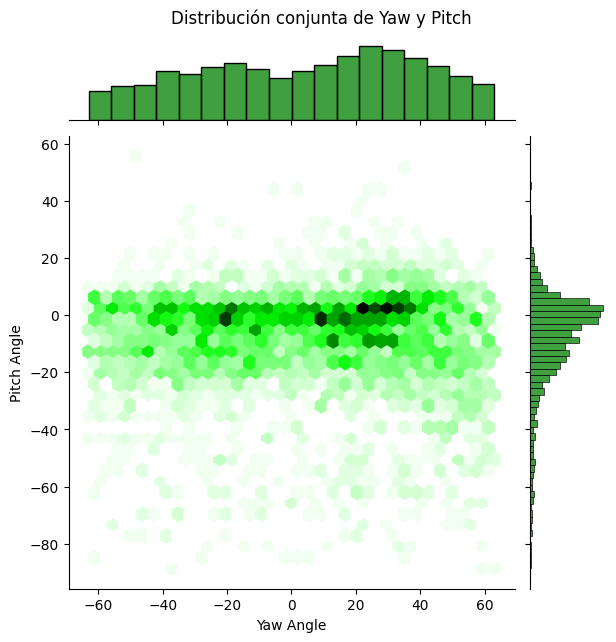

In [ ]:
import seaborn as sns

sns.jointplot(x=yaw_array_deg, y=pitch_array_deg, kind="hex", color="g")
plt.xlabel('Yaw Angle')
plt.ylabel('Pitch Angle')
plt.suptitle('Distribución conjunta de Yaw y Pitch', y=1.03)
plt.show()

## 2. Preparación del dataset

## 2.1 Data augmentation

- Se hace un resize de las imágenes a 224x224 para usar MobileViT pre-entrenado en ImageNet
- Data augmentation:
    - RandomResizedCrop: Recorta y hace zoom en las imágenes de manera aleatoria.
    - ColorJitter: Cambia la saturación y el tono de las imágenes, ligeramente.
    - HorizontalFlip o VerticalFlip: no se pueden usar porque altera el ángulo de la mirada.

In [172]:
WIDTH = 224 
HEIGHT = 224

# Transformación de tamaño y data augmentation
data_transforms = transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((WIDTH, HEIGHT)),
    torchvision.transforms.GaussianBlur(kernel_size=5, sigma=(0.1,1.5)),
    # torchvision.transforms.RandomHorizontalFlip(0.5), # No se puede usar aqui porque altera la dirección de la mirada
    # torchvision.transforms.RandomVerticalFlip(0.5), # No se puede usar aqui porque altera la dirección de la mirada
    # torchvision.transforms.RandomResizedCrop(size=(WIDTH, HEIGHT), scale=(0.9, 1.0)),
    # torchvision.transforms.RandomErasing(p=0.1,scale=(0.02,0.08),ratio=(1,1.7),value="random"),
    torchvision.transforms.ColorJitter(saturation=0.1, hue=0.1),
    # torchvision.transforms.Normalize(mean=[0.2740, 0.2626, 0.2639],std=[0.1757, 0.1787, 0.1761]),
])


In [171]:
# Ahora sí cargamos todas las imágenes que se van a utilizar en el entrenamiento
ds = Gaze360Dataset("./datasets/Gaze360/",images_limit=100,random=True,transform=data_transforms,yaw_limits=[-1.1,1.1])
print(f"Se cargaron {len(ds)} imágenes")

Se cargaron 100 imágenes


## 2.2 Datasets de train y test

In [173]:
# (70% train, 30% test)
train_size = int(0.7*len(ds))  
test_size = len(ds)-train_size

train_dataset, test_dataset = random_split(ds, [train_size, test_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)


In [146]:
torch.cuda.empty_cache()

Shapes: torch.Size([3, 224, 224]) torch.Size([2])
pitch yaw: tensor([ 0.3239, -0.2347])
Pixel_values tensor([0.0049, 0.0050, 0.0078, 0.0172, 0.0253])
Labels: tensor([ 0.3239, -0.2347])


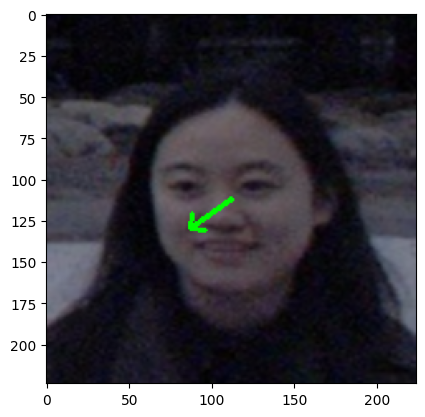

In [139]:
# Visualize a sample
ii =1
train_image = ds[ii]["pixel_values"]
train_labels = ds[ii]["labels"]

print("Shapes:",train_image.shape, train_labels.shape)

# Plot with annotations over it
img = train_image
# img = inverse_normalize(img,mean=torch.tensor([0.2740, 0.2626, 0.2639]),std=torch.tensor([0.1757, 0.1787, 0.1761]))
img = img.permute(1, 2, 0)
img = (img.numpy()*255).astype(np.uint8)
lbl = train_labels
height,width,_ = img.shape
img_annotated = draw_gaze360_arrow(img,lbl,[int(width/2),int(height/2)],scale=80)
plt.imshow(img_annotated)
print(f'pitch yaw: {lbl}')
print("Pixel_values",train_image[0,0,:5])
print("Labels:",train_labels)

# 3. Modelos

Se experimentará con:

- MobileViT
- Algún otro ViT???

## Modelo MobileViT:

- Se cambia la última capa por una capa lineal con dos salidas [yaw,pitch].
- Se utiliza la misma estructura que el modelo de la librería "transformers", para compatibilidad con Trainer y otras funciones de huggingface
- Se crea una dataclass propia para la salida



In [ ]:
@dataclass
class ImageRegressionOutput(ModelOutput):
    """
    Custom output for the regression model. 
    """
    loss: Optional[torch.FloatTensor] = None
    predictions: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None


class MobileViTForImageRegression(MobileViTPreTrainedModel):
    def __init__(self, config: MobileViTConfig) -> None:
        super().__init__(config)

        self.mobilevit = MobileViTModel(config)

        # Regression head
        self.dropout = nn.Dropout(config.classifier_dropout_prob, inplace=True)
        self.regressor = nn.Linear(config.neck_hidden_sizes[-1], 2)  # Output [pitch, yaw]

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        pixel_values: Optional[torch.Tensor] = None,
        output_hidden_states: Optional[bool] = None,
        labels: Optional[torch.Tensor] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[tuple, ImageRegressionOutput]:
        r"""
        Args:
            pixel_values (`torch.Tensor` of shape `(batch_size, num_channels, height, width)`):
                Pixel values for the images.
            output_hidden_states (`bool`, *optional*):
                Whether to return the hidden states.
            labels (`torch.FloatTensor` of shape `(batch_size, 2)`, *optional*):
                Labels for regression loss calculation. Should contain values `[pitch, yaw]`.
            return_dict (`bool`, *optional*):
                Whether to return the output as a dictionary or a tuple.
        
        Returns:
            `ImageRegressionOutput` or `tuple`:
                The output contains predictions, loss (if labels are provided), and optionally hidden states.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.mobilevit(
            pixel_values=pixel_values,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output = outputs.pooler_output if return_dict else outputs[1]
        predictions = self.regressor(self.dropout(pooled_output))

        loss = None
        if labels is not None:
            # print("pixel_values",pixel_values[:,0,0,:5])
            # print("labels",labels)
            loss_fct = MSELoss()
            loss = loss_fct(predictions, labels)

        if not return_dict:
            output = (predictions,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return ImageRegressionOutput(
            loss=loss,
            predictions=predictions,
            hidden_states=outputs.hidden_states,
        )

# Step 1: Define the configuration
config = MobileViTConfig.from_pretrained(
    "apple/mobilevit-small",  # Use the pre-trained MobileViT-small model
)
config.num_labels = 2  # For regression output, we set num_labels to 2 (pitch and yaw)
config.classifier_dropout_prob = 0.0  # Optional: set dropout probability for the regression head

# Step 2: Initialize the MobileViTForImageRegression model
model = MobileViTForImageRegression(config)


In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=25,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=1,
    load_best_model_at_end=True,
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds,
    eval_dataset=ds,
)

In [ ]:
# Train and evaluate
trainer.train()
trainer.evaluate()

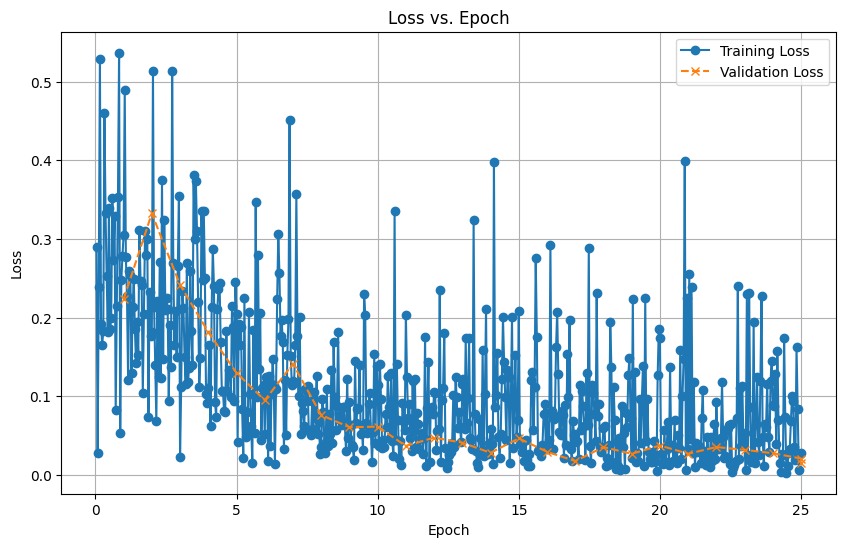

In [153]:
# Extract log history
log_history = trainer.state.log_history

# Extract training loss and epochs
training_loss = [entry["loss"] for entry in log_history if "loss" in entry]
training_epochs = [entry["epoch"] for entry in log_history if "loss" in entry]

# Extract evaluation loss and epochs
eval_loss = [entry["eval_loss"] for entry in log_history if "eval_loss" in entry]
eval_epochs = [entry["epoch"] for entry in log_history if "eval_loss" in entry]

# Plot training and evaluation loss vs. epoch
plt.figure(figsize=(10, 6))
plt.plot(training_epochs, training_loss, marker="o", label="Training Loss")
plt.plot(eval_epochs, eval_loss, marker="x", label="Validation Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()
plt.grid()
plt.show()

## 3.9 Validación

Se elige una imagen al azar y se compara con las etiquetas que trae el dataset.
- Flecha Azul: "groundtruth", la mirada que está etiquetada en el dataset.
- Felcha verde: mirada predicha.

In [ ]:
# # Se elige el mejor modelo para validación
# loaded_model = GazeEstimation_MobileNet()
# loaded_model.load_state_dict(torch.load('./modelos/gaze360/mobilenet__epochs_100__lr_1Em4_filtered_yaw.pth'))
# loaded_model.to(device)

# # Sanity check
# inputs = torch.randn(8, 3, 224, 224).to(device) 
# outputs = loaded_model(inputs) 

# print(outputs)

In [182]:
import time

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Prediction time: 47.55ms 
Actual: 
	 pitch=-0.967 rad | yaw=-0.228 rad
	 proyección 2D del ángulo: 285.76° deg
Predicted: 
	 pitch=-0.149 rad | yaw=-0.099 rad
	 proyección 2D del ángulo: 326.69° deg
**Preciso (tolerancia = 15°): 0


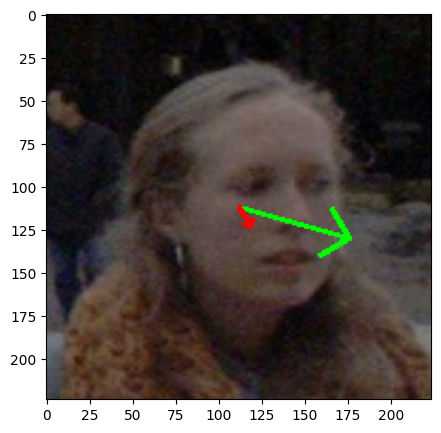

In [ ]:
# Pick model
# model = loaded_model

# Randomly select image and its labels
data = ds[randint(0,len(train_dataset)-1)]
img = data["pixel_values"]
gaze = data["labels"]
pitch = data["labels"][0]
yaw = data["labels"][1]
angle = angle_to_2d(np.array([gaze]))

# Get start time
start_time = time.time()

# Run inference and get prediction
predicted_gaze = model(img.unsqueeze(0).to(device))
yaw_predicted = predicted_gaze["predictions"][0][0].item()
pitch_predicted = predicted_gaze["predictions"][0][1].item()
img = img.squeeze(0).detach().cpu().numpy().transpose(1,2,0)
predicted_gaze = predicted_gaze["predictions"].squeeze(0).detach().cpu().numpy()
angle_predicted = angle_to_2d(np.array([predicted_gaze]))

# Get end time
end_time = time.time()

# Print prediction time
prediction_time = end_time - start_time
print(f"Tiempo de predicción: {prediction_time*1000:.2f}ms ")

# Define error tolerance
tolerancia = 15 # 15 degrees
accurate = int(is_accurate(angle,angle_predicted,tolerance=tolerancia)[0])

# Print results
print("Actual: ")
print(f"\t pitch={pitch:.3f} rad | yaw={yaw:.3f} rad")
print(f"\t proyección 2D del ángulo: {angle[0]:.2f}° deg")
print("Predicted: ")
print(f"\t pitch={pitch_predicted:.3f} rad | yaw={yaw_predicted:.3f} rad")
print(f"\t proyección 2D del ángulo: {angle_predicted[0]:.2f}° deg")
print(f"**Preciso (tolerancia = {tolerancia}°): {accurate}")

# Add annotations
img = draw_gaze360_arrow(img,gaze,"center",scale=80)
img = draw_gaze360_arrow(img,predicted_gaze,"center",color=(255,0,0),scale=80)
# img = put_gaze_annotation(img,predicted_gaze,method=1,color=(0,255,0), label="Predicted",label_y=22) #Prediced: green
# img = put_gaze_annotation(img,gaze,method=1,color=(255,0,0),label="Actual",label_y=10) #Actual: blue

# Show images (after converting it from BGR to RGB)
plt.figure(figsize=(5,5))
plt.imshow(img)